# Piezometer Landslide Prediction System

This notebook implements an advanced machine learning-based landslide prediction system using piezometer data. The system monitors groundwater pressure and level changes to predict potential landslide events.

## System Components
1. Data Collection and Management (Piezometer Readings)
2. Data Preprocessing and Feature Engineering
3. Exploratory Data Analysis
4. Model Training (Random Forest & Gradient Boosting)
5. Prediction Pipeline
6. Risk Visualization and Alerts

## Data Fields
- **timestamp**: Date and time of measurement
- **pore_pressure**: Pore water pressure (kPa)
- **groundwater_level**: Water table depth (m)
- **pressure_change_rate**: Rate of pressure change (kPa/day)
- **point_coordinates**: 3D location (x, y, z)

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for piezometer data processing and analysis.

In [17]:
# Import required libraries
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, classification_report
import joblib
import warnings
import json
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# DIRECTORY STRUCTURE SETUP
# ============================================================================
# Base directories
BASE_DIR = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
if 'backend' in BASE_DIR:
    BASE_DIR = os.path.dirname(BASE_DIR)

DATA_DIR = os.path.join(BASE_DIR, 'Data')
UPLOAD_DIR = os.path.join(BASE_DIR, 'Upload')
PIEZOMETER_DIR = os.path.join(UPLOAD_DIR, 'Piezometer')

# Piezometer subdirectories
IMAGES_DIR = os.path.join(PIEZOMETER_DIR, 'images')
ANALYSIS_DIR = os.path.join(PIEZOMETER_DIR, 'Analysis')
REPORT_DIR = os.path.join(PIEZOMETER_DIR, 'Report')

# Create directory structure
for directory in [DATA_DIR, PIEZOMETER_DIR, IMAGES_DIR, ANALYSIS_DIR, REPORT_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define file paths
DATA_FILE = os.path.join(DATA_DIR, 'piezometer_data.csv')

# ============================================================================
# NON-OVERWRITE VERSIONING SYSTEM
# ============================================================================
def get_next_filename(directory, base_name, extension):
    """
    Generate next versioned filename to prevent overwriting.
    Example: file.png -> file_1.png -> file_2.png
    
    Args:
        directory: Target directory path
        base_name: Base filename without extension
        extension: File extension (e.g., '.png', '.csv')
    
    Returns:
        Full path to next available versioned filename
    """
    # Check for existing files
    pattern = os.path.join(directory, f"{base_name}*{extension}")
    existing_files = glob.glob(pattern)
    
    if not existing_files:
        # No existing files, use base name
        return os.path.join(directory, f"{base_name}{extension}")
    
    # Find highest version number
    max_version = 0
    for filepath in existing_files:
        filename = os.path.basename(filepath)
        # Match pattern: base_name_N.extension or base_name.extension
        match = re.search(rf"{re.escape(base_name)}_(\d+){re.escape(extension)}$", filename)
        if match:
            version = int(match.group(1))
            max_version = max(max_version, version)
        elif filename == f"{base_name}{extension}":
            max_version = max(max_version, 0)
    
    # Return next version
    next_version = max_version + 1
    return os.path.join(directory, f"{base_name}_{next_version}{extension}")

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================
print("=" * 70)
print("✓ PIEZOMETER LANDSLIDE PREDICTION SYSTEM INITIALIZED")
print("=" * 70)
print(f"\n📁 Directory Structure:")
print(f"   Base Directory: {BASE_DIR}")
print(f"   Data Directory: {DATA_DIR}")
print(f"   Upload Directory: {UPLOAD_DIR}")
print(f"\n📂 Piezometer Folders:")
print(f"   Images: {IMAGES_DIR}")
print(f"   Analysis: {ANALYSIS_DIR}")
print(f"   Reports: {REPORT_DIR}")
print(f"\n📄 Data File:")
print(f"   Location: {DATA_FILE}")
print(f"   Exists: {os.path.exists(DATA_FILE)}")
print(f"\n✓ Libraries imported successfully")
print(f"✓ Non-overwrite versioning system enabled")
print("=" * 70)

✓ PIEZOMETER LANDSLIDE PREDICTION SYSTEM INITIALIZED

📁 Directory Structure:
   Base Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction
   Data Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data
   Upload Directory: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload

📂 Piezometer Folders:
   Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images
   Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\Analysis
   Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\Report

📄 Data File:
   Location: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data\piezometer_data.csv
   Exists: True

✓ Libraries imported successfully
✓ Non-overwrite versioning system enabled


## 2. Data Generation and Management

Create synthetic piezometer data for landslide monitoring or load existing data. The system simulates 2 readings per day with realistic pressure and groundwater patterns.

In [4]:
def generate_piezometer_data(n_samples=60):
    """
    Generate synthetic piezometer data with realistic groundwater patterns.
    Creates 2 readings per day over 30 days.
    """
    data = {
        'timestamp': [],
        'pore_pressure': [],
        'groundwater_level': [],
        'pressure_change_rate': [],
        'point_coordinates': [],
        'risk_class': []
    }
    
    # Generate timestamps (2 readings per day)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=n_samples/2)
    timestamps = []
    current_date = start_date
    while current_date <= end_date:
        timestamps.extend([current_date, current_date + timedelta(hours=12)])
        current_date += timedelta(days=1)
    timestamps = timestamps[:n_samples]
    
    # Generate synthetic piezometer measurements
    base_pressure = 50  # kPa baseline
    base_water_level = 5  # meters baseline
    
    for i in range(n_samples):
        # Simulate pressure increase over time with variation
        pressure_trend = i * 0.3  # Increasing trend
        pressure_noise = np.random.normal(0, 5)
        pore_pressure = base_pressure + pressure_trend + pressure_noise
        
        # Groundwater level (higher = shallower = more dangerous)
        water_level = base_water_level - (i * 0.05) + np.random.normal(0, 0.5)
        water_level = max(0.5, water_level)  # Keep above minimum
        
        # Pressure change rate
        if i == 0:
            pressure_rate = 0
        else:
            pressure_rate = (pore_pressure - data['pore_pressure'][-1]) / 0.5  # per day
        
        data['timestamp'].append(timestamps[i])
        data['pore_pressure'].append(pore_pressure)
        data['groundwater_level'].append(water_level)
        data['pressure_change_rate'].append(pressure_rate)
        
        # 3D coordinates (x, y, z - elevation)
        x = np.random.uniform(0, 100)
        y = np.random.uniform(0, 100)
        z = np.random.uniform(300, 500)  # Elevation in meters
        data['point_coordinates'].append(f"{x:.2f}, {y:.2f}, {z:.2f}")
        
        # Risk classification based on pressure and water level
        if pore_pressure > 65 or water_level < 2:
            risk = 'High'
        elif pore_pressure > 55 or water_level < 3.5:
            risk = 'Medium'
        else:
            risk = 'Low'
        data['risk_class'].append(risk)
    
    return pd.DataFrame(data)

def load_or_create_piezometer_data():
    """
    Load existing piezometer data from Data folder or create new synthetic data if file doesn't exist.
    Follows the rule: Check Data folder → Load if exists → Generate and save if not
    """
    if os.path.exists(DATA_FILE):
        # Data exists in Data folder - load it
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        print("=" * 70)
        print("📂 DATA CHECK: File exists in Data folder")
        print("=" * 70)
        print(f"✓ Loaded existing data from: {DATA_FILE}")
        print(f"✓ Total records: {len(existing_data)}")
        print(f"✓ Date range: {existing_data['timestamp'].min()} to {existing_data['timestamp'].max()}")
        print("=" * 70)
        return existing_data
    else:
        # Data does not exist - generate it and save to Data folder
        print("=" * 70)
        print("📂 DATA CHECK: File does not exist in Data folder")
        print("=" * 70)
        print("🔄 Generating synthetic piezometer data...")
        new_data = generate_piezometer_data()
        new_data.to_csv(DATA_FILE, index=False)
        print(f"✓ Generated new data: {len(new_data)} records")
        print(f"✓ Saved to: {DATA_FILE}")
        print(f"✓ Date range: {new_data['timestamp'].min()} to {new_data['timestamp'].max()}")
        print("=" * 70)
        return new_data

# Load or generate initial data
df = load_or_create_piezometer_data()
print(f"\n📊 Dataset Information:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
df.head()

📂 DATA CHECK: File exists in Data folder
✓ Loaded existing data from: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data\piezometer_data.csv
✓ Total records: 62
✓ Date range: 2025-09-18 10:51:10.920603 to 2025-10-17 22:55:03.015209

📊 Dataset Information:
   Shape: (62, 6)
   Columns: ['timestamp', 'pore_pressure', 'groundwater_level', 'pressure_change_rate', 'point_coordinates', 'risk_class']


,timestamp,pore_pressure,groundwater_level,pressure_change_rate,point_coordinates,risk_class
0,2025-09-18 10:51:10.920603,52.483571,4.930868,0.000000,"73.20, 59.87, 331.20",Low
1,2025-09-18 22:51:10.920603,51.695206,5.455258,-1.576729,"70.81, 2.06, 493.98",Low
2,2025-09-19 10:51:10.920603,48.252628,5.171280,-6.885157,"18.18, 18.34, 360.85",Low
3,2025-09-19 22:51:10.920603,37.837255,5.325185,-20.830746,"29.12, 61.19, 327.90",Low
4,2025-09-20 10:51:10.920603,46.659880,4.093848,17.645249,"45.61, 78.52, 339.93",Low


## 3. Data Preprocessing and Feature Engineering

Prepare the data for analysis by handling missing values, scaling numerical features, and creating derived features.

In [5]:
def preprocess_piezometer_data(df):
    """
    Preprocess piezometer data and engineer new features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['pore_pressure', 'groundwater_level', 'pressure_change_rate']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(processed_df[numeric_columns].mean())
    
    # Feature engineering
    # 1. Pressure-water level ratio (higher = more risk)
    processed_df['pressure_water_ratio'] = processed_df['pore_pressure'] / (processed_df['groundwater_level'] + 1e-6)
    
    # 2. Cumulative pressure change
    processed_df['cumulative_pressure_change'] = processed_df['pore_pressure'].diff().fillna(0).cumsum()
    
    # 3. Pressure acceleration (rate of rate change)
    processed_df['pressure_acceleration'] = processed_df['pressure_change_rate'].diff().fillna(0)
    
    # 4. Water level change rate
    processed_df['water_level_change_rate'] = processed_df['groundwater_level'].diff().fillna(0)
    
    # 5. Critical zone indicator (high pressure + shallow water)
    processed_df['critical_zone'] = ((processed_df['pore_pressure'] > 60) & 
                                     (processed_df['groundwater_level'] < 3)).astype(int)
    
    # Extract coordinates for analysis
    coords = processed_df['point_coordinates'].str.split(',', expand=True)
    processed_df['coord_x'] = coords[0].astype(float)
    processed_df['coord_y'] = coords[1].astype(float)
    processed_df['coord_z'] = coords[2].astype(float)
    
    # Replace inf values
    processed_df.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Create binary target for landslide occurrence (High risk = 1, others = 0)
    processed_df['landslide_likely'] = (processed_df['risk_class'] == 'High').astype(int)
    
    # Calculate days until potential event (for regression)
    processed_df['days_until_event'] = processed_df.apply(
        lambda row: 1 if row['risk_class'] == 'High' 
        else 3 if row['risk_class'] == 'Medium'
        else 7, axis=1
    )
    
    # Scale numerical features
    scaler = StandardScaler()
    numeric_features = numeric_columns + ['pressure_water_ratio', 'cumulative_pressure_change', 
                                         'pressure_acceleration', 'water_level_change_rate',
                                         'coord_x', 'coord_y', 'coord_z']
    processed_df[numeric_features] = scaler.fit_transform(processed_df[numeric_features])
    
    return processed_df, scaler

# Process the data
processed_df, scaler = preprocess_piezometer_data(df)
print("✓ Data preprocessing completed")
print(f"\nProcessed features: {len(processed_df.columns)} columns")
print(f"Engineered features: pressure_water_ratio, cumulative_pressure_change, pressure_acceleration, water_level_change_rate, critical_zone")
print(f"\nRisk distribution:")
print(processed_df['risk_class'].value_counts())
processed_df.head()

✓ Data preprocessing completed

Processed features: 16 columns
Engineered features: pressure_water_ratio, cumulative_pressure_change, pressure_acceleration, water_level_change_rate, critical_zone

Risk distribution:
risk_class
Medium    31
Low       17
High      14
Name: count, dtype: int64


,timestamp,pore_pressure,groundwater_level,pressure_change_rate,point_coordinates,risk_class,pressure_water_ratio,cumulative_pressure_change,pressure_acceleration,water_level_change_rate,critical_zone,coord_x,coord_y,coord_z,landslide_likely,days_until_event
0,2025-09-18 10:51:10.920603,-0.792895,1.314631,-0.021406,"73.20, 59.87, 331.20",Low,-1.021356,-0.792895,0.009449,-0.017648,0,0.946069,0.400003,-1.150651,0,7
1,2025-09-18 22:51:10.920603,-0.893464,1.876425,-0.127293,"70.81, 2.06, 493.98",Low,-1.198579,-0.893464,-0.054506,0.583063,0,0.864950,-1.588733,1.628298,0,7
2,2025-09-19 10:51:10.920603,-1.332624,1.572192,-0.483786,"18.18, 18.34, 360.85",Low,-1.220636,-1.332624,-0.205870,-0.342956,0,-0.921368,-1.028680,-0.644472,0,7
3,2025-09-19 22:51:10.920603,-2.661284,1.737075,-1.420317,"29.12, 61.19, 327.90",Low,-1.558421,-2.661284,-0.556208,0.158657,0,-0.550053,0.445413,-1.206988,0,7
4,2025-09-20 10:51:10.920603,-1.535807,0.417906,1.163579,"45.61, 78.52, 339.93",Low,-0.906965,-1.535807,1.570102,-1.428197,0,0.009635,1.041587,-1.001614,0,7


## 4. Exploratory Data Analysis

Analyze patterns and relationships in the piezometer data through advanced visualizations and statistical summaries.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\pressure_trends.png


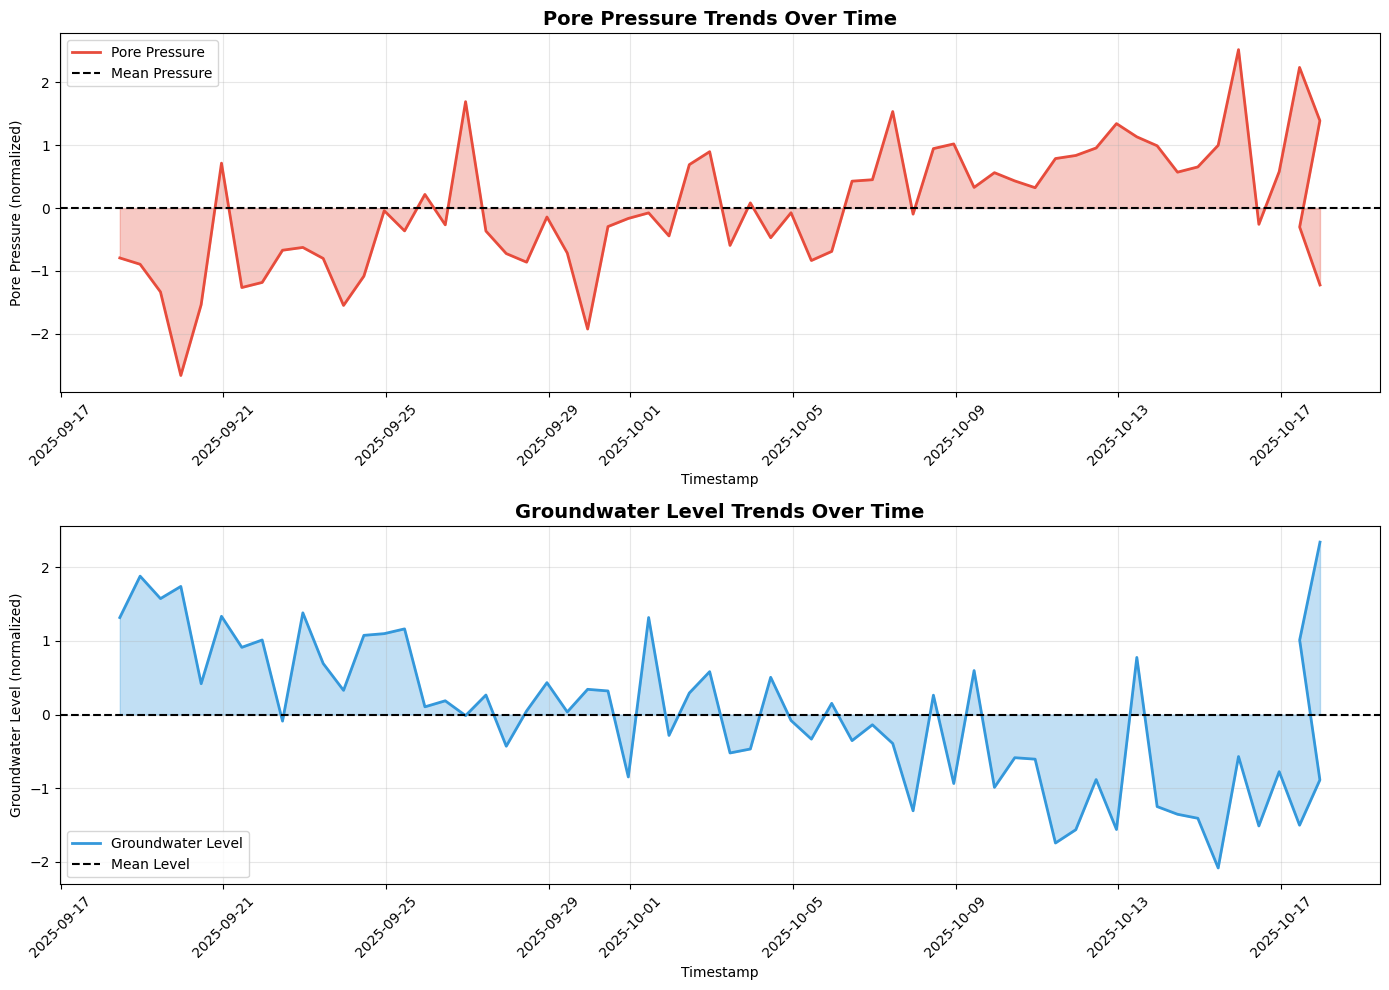

Insight: Rising pore pressure combined with decreasing groundwater level indicates increasing landslide risk.


In [6]:
# 1. Pore Pressure and Groundwater Level Trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Pore pressure over time
ax1.plot(processed_df['timestamp'], processed_df['pore_pressure'], 
         label='Pore Pressure', color='#E74C3C', linewidth=2)
ax1.fill_between(processed_df['timestamp'], processed_df['pore_pressure'],
                 alpha=0.3, color='#E74C3C')
ax1.axhline(y=processed_df['pore_pressure'].mean(), color='black', 
           linestyle='--', label='Mean Pressure')
ax1.set_title('Pore Pressure Trends Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Pore Pressure (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Groundwater level over time
ax2.plot(processed_df['timestamp'], processed_df['groundwater_level'], 
         label='Groundwater Level', color='#3498DB', linewidth=2)
ax2.fill_between(processed_df['timestamp'], processed_df['groundwater_level'],
                 alpha=0.3, color='#3498DB')
ax2.axhline(y=processed_df['groundwater_level'].mean(), color='black', 
           linestyle='--', label='Mean Level')
ax2.set_title('Groundwater Level Trends Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Groundwater Level (normalized)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'pressure_trends', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("Insight: Rising pore pressure combined with decreasing groundwater level indicates increasing landslide risk.")

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\correlation_heatmap.png


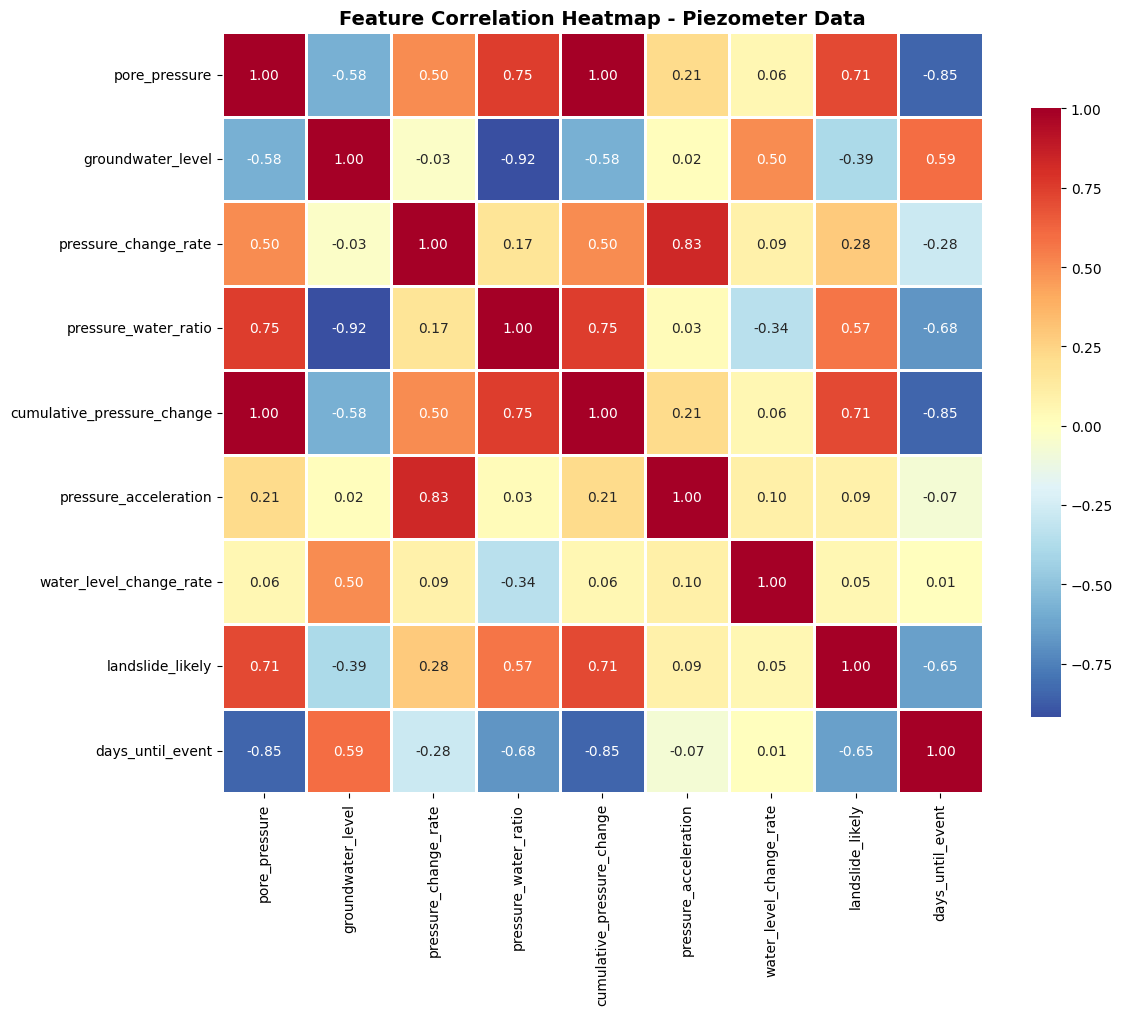

Insight: Strong correlation between pressure_water_ratio and landslide risk, indicating critical monitoring parameter.


In [7]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_cols = ['pore_pressure', 'groundwater_level', 'pressure_change_rate',
                'pressure_water_ratio', 'cumulative_pressure_change', 
                'pressure_acceleration', 'water_level_change_rate',
                'landslide_likely', 'days_until_event']
correlation_matrix = processed_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap - Piezometer Data', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'correlation_heatmap', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("Insight: Strong correlation between pressure_water_ratio and landslide risk, indicating critical monitoring parameter.")

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\risk_distribution.png


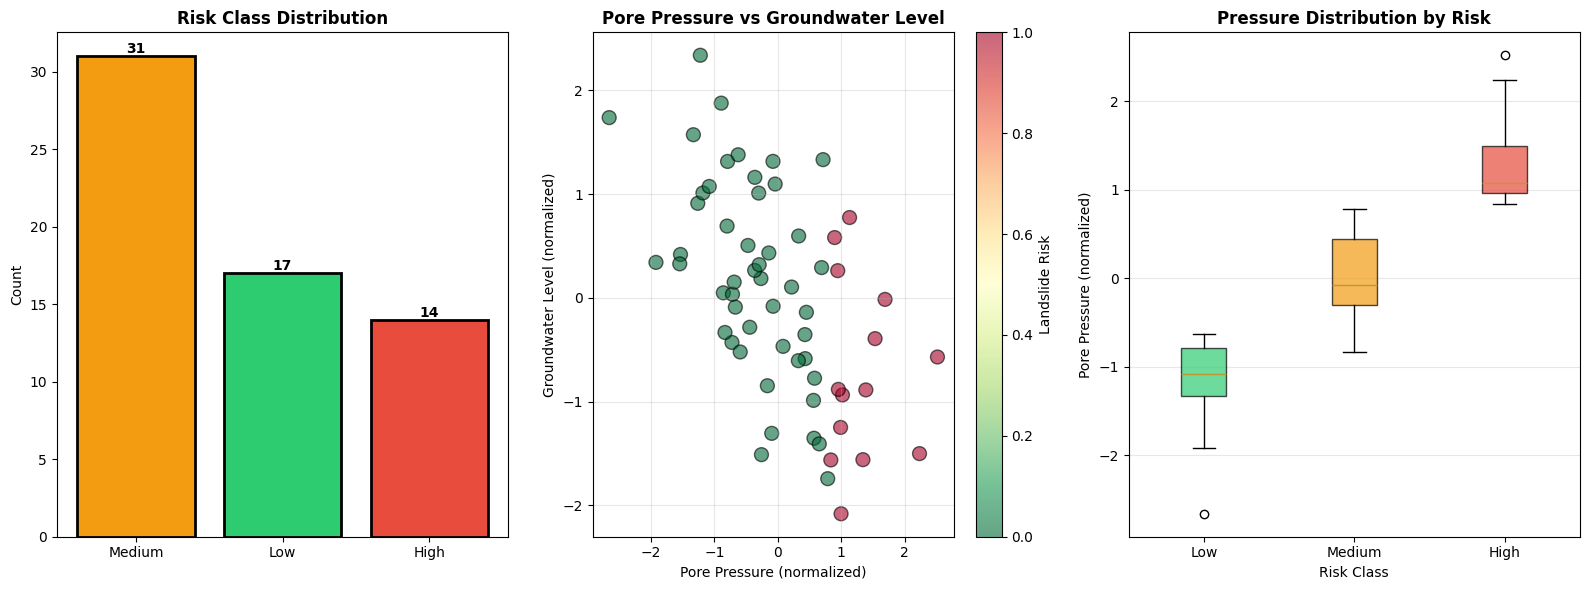

Insight: High-risk zones show elevated pore pressure combined with low groundwater levels.


In [8]:
# 3. Risk Distribution and Pressure vs Water Level Analysis
fig = plt.figure(figsize=(16, 6))

# Risk distribution
ax1 = plt.subplot(131)
risk_counts = processed_df['risk_class'].value_counts()
colors_risk = {'Low': '#2ECC71', 'Medium': '#F39C12', 'High': '#E74C3C'}
bars = ax1.bar(risk_counts.index, risk_counts.values, 
               color=[colors_risk[x] for x in risk_counts.index],
               edgecolor='black', linewidth=2)
ax1.set_title('Risk Class Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Pressure vs Water Level scatter
ax2 = plt.subplot(132)
scatter = ax2.scatter(processed_df['pore_pressure'], 
                     processed_df['groundwater_level'],
                     c=processed_df['landslide_likely'], 
                     cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black')
ax2.set_xlabel('Pore Pressure (normalized)')
ax2.set_ylabel('Groundwater Level (normalized)')
ax2.set_title('Pore Pressure vs Groundwater Level', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Landslide Risk')

# Box plot by risk class
ax3 = plt.subplot(133)
pressure_by_risk = [processed_df[processed_df['risk_class'] == risk]['pore_pressure'].values 
                   for risk in ['Low', 'Medium', 'High']]
bp = ax3.boxplot(pressure_by_risk, labels=['Low', 'Medium', 'High'],
                patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2ECC71', '#F39C12', '#E74C3C']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Risk Class')
ax3.set_ylabel('Pore Pressure (normalized)')
ax3.set_title('Pressure Distribution by Risk', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'risk_distribution', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("Insight: High-risk zones show elevated pore pressure combined with low groundwater levels.")

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\pressure_change_rate.png


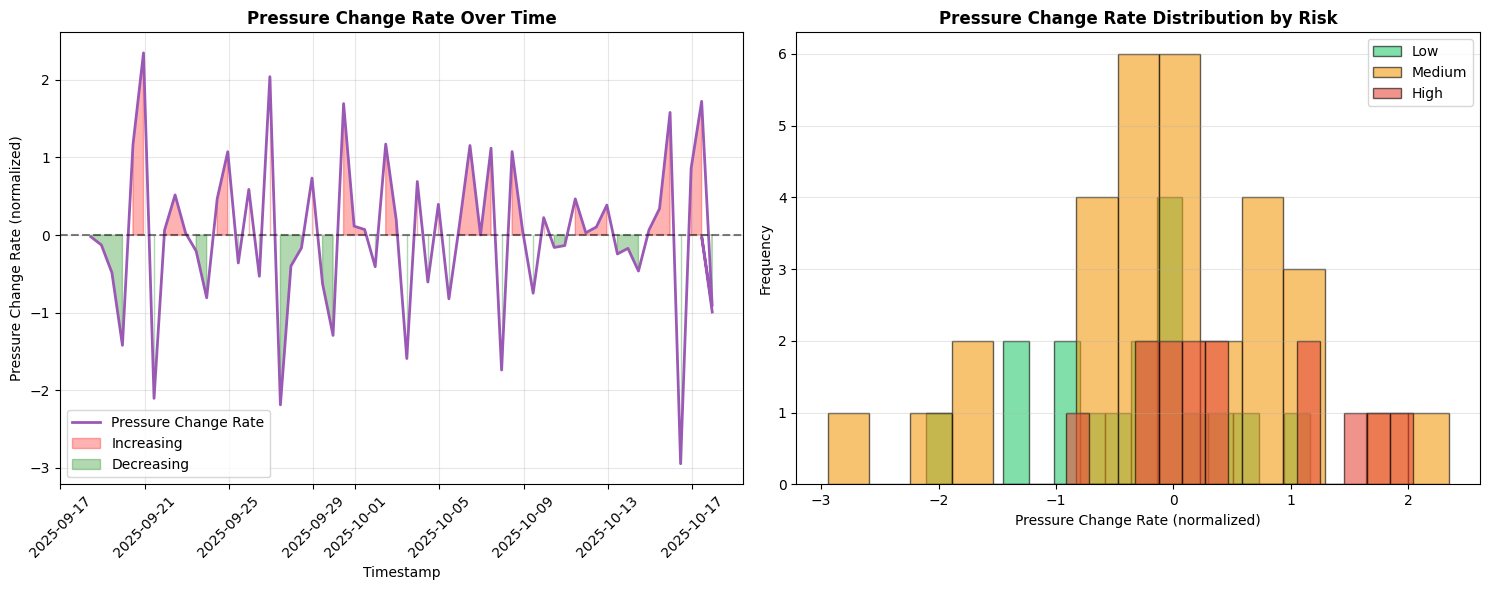

Insight: Rapid pressure changes indicate instability and higher landslide risk.


In [9]:
# 4. Pressure Change Rate Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time series of pressure change rate
ax1.plot(processed_df['timestamp'], processed_df['pressure_change_rate'],
        color='#9B59B6', linewidth=2, label='Pressure Change Rate')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(processed_df['timestamp'], processed_df['pressure_change_rate'],
                where=(processed_df['pressure_change_rate'] > 0), 
                alpha=0.3, color='red', label='Increasing')
ax1.fill_between(processed_df['timestamp'], processed_df['pressure_change_rate'],
                where=(processed_df['pressure_change_rate'] <= 0), 
                alpha=0.3, color='green', label='Decreasing')
ax1.set_title('Pressure Change Rate Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Pressure Change Rate (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Histogram of pressure change rates by risk
for risk, color in zip(['Low', 'Medium', 'High'], ['#2ECC71', '#F39C12', '#E74C3C']):
    data = processed_df[processed_df['risk_class'] == risk]['pressure_change_rate']
    ax2.hist(data, bins=15, alpha=0.6, label=risk, color=color, edgecolor='black')
ax2.set_title('Pressure Change Rate Distribution by Risk', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pressure Change Rate (normalized)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'pressure_change_rate', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("Insight: Rapid pressure changes indicate instability and higher landslide risk.")

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\3d_spatial_distribution.png


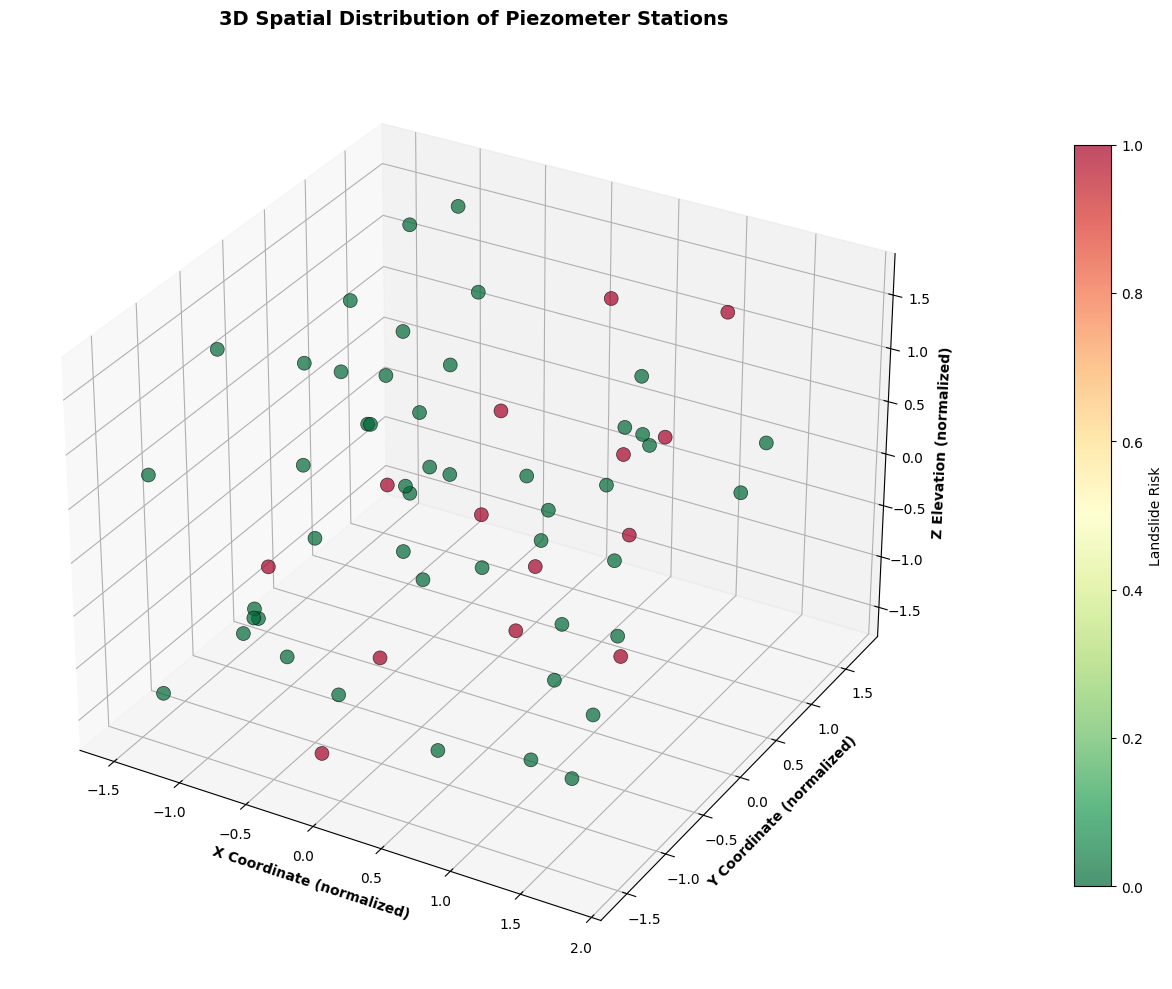

Insight: 3D visualization reveals spatial clustering of high-risk zones, useful for targeted monitoring.


In [10]:
# 5. 3D Spatial Distribution of Piezometers
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
coords_x = processed_df['coord_x']
coords_y = processed_df['coord_y']
coords_z = processed_df['coord_z']
risk_values = processed_df['landslide_likely']

scatter = ax.scatter(coords_x, coords_y, coords_z,
                    c=risk_values, cmap='RdYlGn_r', 
                    s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('X Coordinate (normalized)', fontweight='bold')
ax.set_ylabel('Y Coordinate (normalized)', fontweight='bold')
ax.set_zlabel('Z Elevation (normalized)', fontweight='bold')
ax.set_title('3D Spatial Distribution of Piezometer Stations', 
            fontsize=14, fontweight='bold', pad=20)
cbar = plt.colorbar(scatter, ax=ax, label='Landslide Risk', pad=0.1, shrink=0.8)

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, '3d_spatial_distribution', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("Insight: 3D visualization reveals spatial clustering of high-risk zones, useful for targeted monitoring.")

## 5. Model Development

Train and evaluate Random Forest for landslide occurrence prediction and Gradient Boosting for timing prediction.

MODEL TRAINING
Training set size: 43
Testing set size: 19
Number of features: 10

 Training Random Forest Classifier...
✓ Training Gradient Boosting Regressor...

MODEL PERFORMANCE

🎯 Random Forest Classifier (Landslide Occurrence):
   Accuracy: 0.947
   F1 Score: 0.909

🎯 Gradient Boosting Regressor (Days Until Event):
   R² Score: 0.839

📊 Detailed Classification Report:
                precision    recall  f1-score   support

          Safe       0.93      1.00      0.96        13
Landslide Risk       1.00      0.83      0.91         6

      accuracy                           0.95        19
     macro avg       0.96      0.92      0.94        19
  weighted avg       0.95      0.95      0.95        19

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\model_performance.png
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\model_performance.png


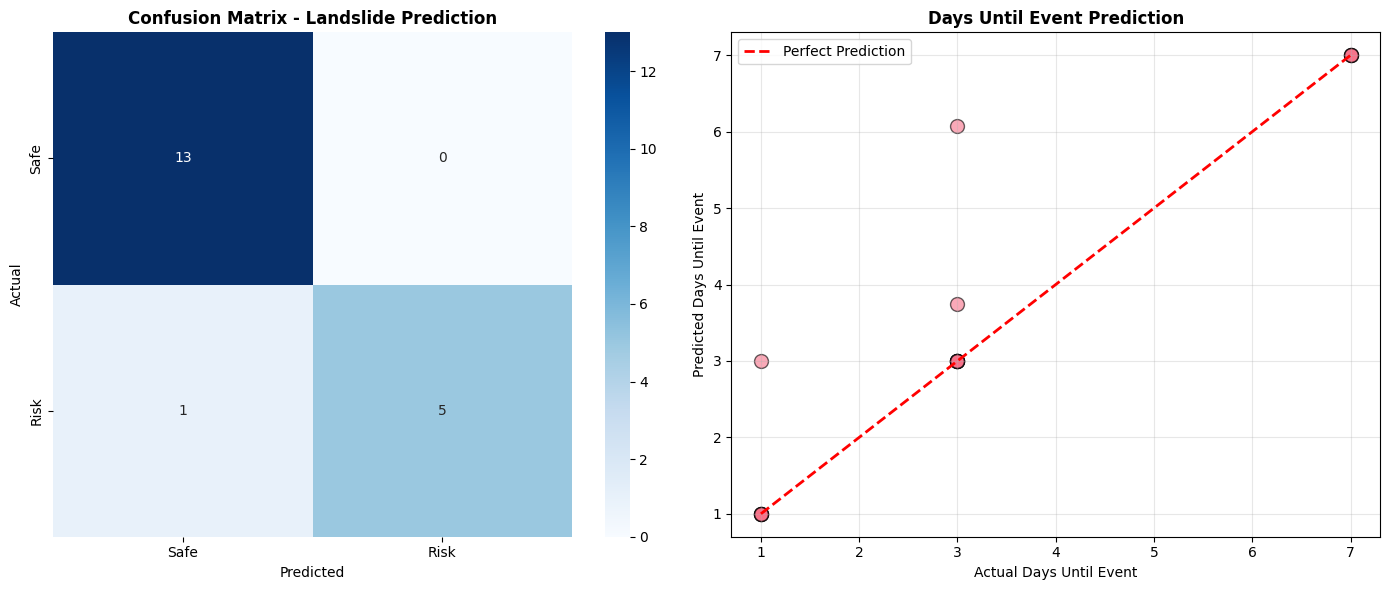


✓ Models saved successfully!
   RF Model: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\Analysis\rf_model.joblib
   GB Model: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\Analysis\gb_model.joblib


In [11]:
# Prepare features for modeling
feature_cols = ['pore_pressure', 'groundwater_level', 'pressure_change_rate',
                'pressure_water_ratio', 'cumulative_pressure_change',
                'pressure_acceleration', 'water_level_change_rate',
                'coord_x', 'coord_y', 'coord_z']

# Split data for both models
X = processed_df[feature_cols]
y_clf = processed_df['landslide_likely']
y_reg = processed_df['days_until_event']

X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf, y_reg, test_size=0.3, random_state=42
)

print("="*80)
print("MODEL TRAINING")
print("="*80)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")

# Train Random Forest Classifier
print("\n Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_clf_train)

# Train Gradient Boosting Regressor
print("✓ Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
gb_model.fit(X_train, y_reg_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)
gb_pred = gb_model.predict(X_test)

# Calculate metrics
clf_accuracy = accuracy_score(y_clf_test, rf_pred)
clf_f1 = f1_score(y_clf_test, rf_pred)
reg_r2 = r2_score(y_reg_test, gb_pred)

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print("\n🎯 Random Forest Classifier (Landslide Occurrence):")
print(f"   Accuracy: {clf_accuracy:.3f}")
print(f"   F1 Score: {clf_f1:.3f}")

print("\n🎯 Gradient Boosting Regressor (Days Until Event):")
print(f"   R² Score: {reg_r2:.3f}")

# Classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_clf_test, rf_pred, target_names=['Safe', 'Landslide Risk']))

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
cm = confusion_matrix(y_clf_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=['Safe', 'Risk'], yticklabels=['Safe', 'Risk'])
ax1.set_title('Confusion Matrix - Landslide Prediction', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Regression scatter
ax2.scatter(y_reg_test, gb_pred, alpha=0.6, s=100, edgecolors='black')
ax2.plot([y_reg_test.min(), y_reg_test.max()], 
        [y_reg_test.min(), y_reg_test.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Days Until Event')
ax2.set_ylabel('Predicted Days Until Event')
ax2.set_title('Days Until Event Prediction', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'model_performance', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

# Save models to Analysis folder with versioning
rf_model_path = get_next_filename(ANALYSIS_DIR, 'rf_model', '.joblib')
gb_model_path = get_next_filename(ANALYSIS_DIR, 'gb_model', '.joblib')
joblib.dump(rf_model, rf_model_path)
joblib.dump(gb_model, gb_model_path)
print("\n✓ Models saved successfully!")
print(f"   RF Model: {rf_model_path}")
print(f"   GB Model: {gb_model_path}")

## 6. Feature Importance and Predictions

Analyze which piezometer measurements are most critical for landslide prediction.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\feature_importance.png


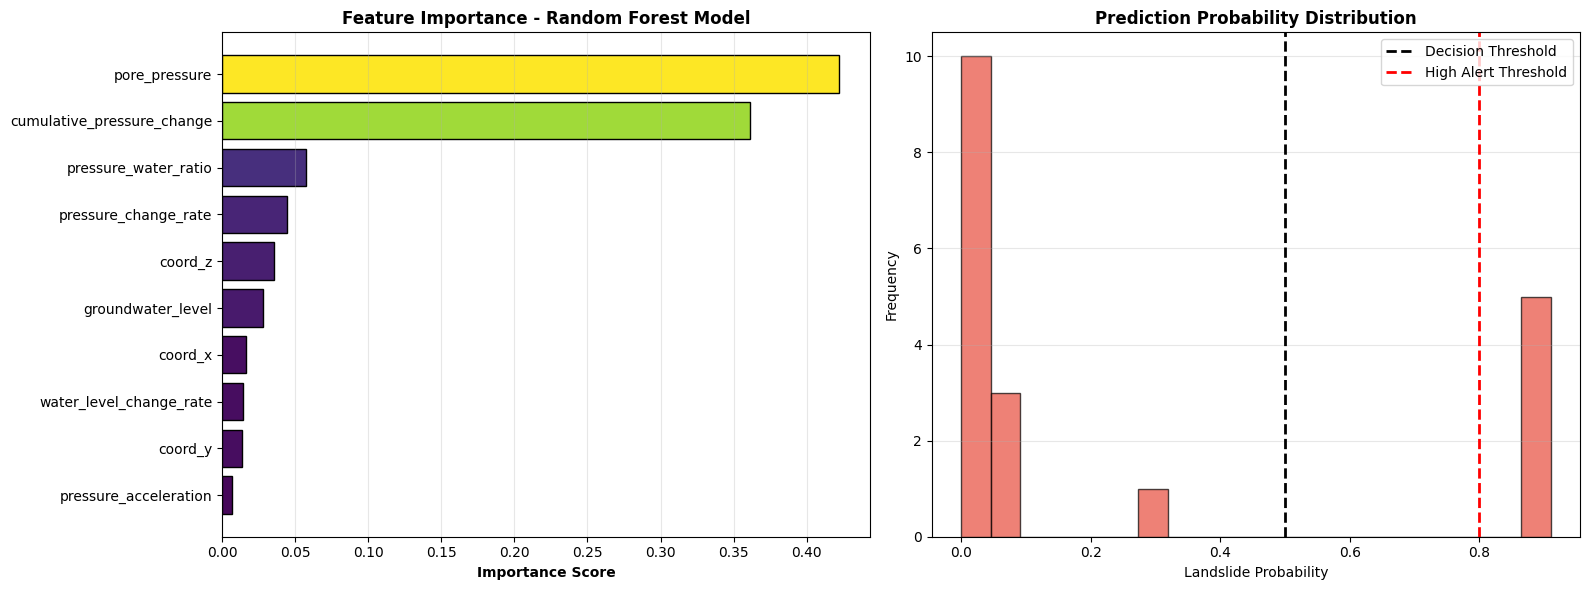

TOP 5 MOST IMPORTANT FEATURES
pore_pressure                  → 0.4222
cumulative_pressure_change     → 0.3613
pressure_water_ratio           → 0.0573
pressure_change_rate           → 0.0445
coord_z                        → 0.0357

SAMPLE PREDICTIONS
   occurrence_probability  predicted_days_until_event alert_level
0                    0.87                    1.000075        HIGH
1                    0.05                    3.000022         LOW
2                    0.00                    6.999916         LOW
3                    0.06                    3.000022         LOW
4                    0.05                    3.000022         LOW
5                    0.87                    1.000075        HIGH
6                    0.01                    3.000022         LOW
7                    0.03                    6.999916         LOW
8                    0.00                    3.000022         LOW
9                    0.89                    1.000075        HIGH

✓ Predictions saved to:

In [12]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance bar chart
colors_imp = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
ax1.barh(feature_importance['feature'], feature_importance['importance'], color=colors_imp, edgecolor='black')
ax1.set_xlabel('Importance Score', fontweight='bold')
ax1.set_title('Feature Importance - Random Forest Model', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Prediction probability distribution
test_probs = rf_model.predict_proba(X_test)[:, 1]
ax2.hist(test_probs, bins=20, edgecolor='black', alpha=0.7, color='#E74C3C')
ax2.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax2.axvline(0.8, color='red', linestyle='--', linewidth=2, label='High Alert Threshold')
ax2.set_xlabel('Landslide Probability')
ax2.set_ylabel('Frequency')
ax2.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'feature_importance', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

print("="*80)
print("TOP 5 MOST IMPORTANT FEATURES")
print("="*80)
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']:30s} → {row['importance']:.4f}")

# Make predictions and log
def predict_landslide_risk(new_data_features):
    """
    Make predictions on new piezometer data.
    """
    occurrence_prob = rf_model.predict_proba(new_data_features)[:, 1]
    days_prediction = gb_model.predict(new_data_features)
    
    results = pd.DataFrame({
        'occurrence_probability': occurrence_prob,
        'predicted_days_until_event': days_prediction,
        'alert_level': ['HIGH' if p > 0.8 else 'MEDIUM' if p > 0.5 else 'LOW' for p in occurrence_prob]
    })
    
    return results

# Example predictions on test set
test_predictions = predict_landslide_risk(X_test)
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)
print(test_predictions.head(10))

# Save predictions to Analysis folder with versioning
predictions_with_timestamp = test_predictions.copy()
predictions_with_timestamp['timestamp'] = pd.Timestamp.now()
pred_file = get_next_filename(ANALYSIS_DIR, 'prediction', '.csv')
predictions_with_timestamp.to_csv(pred_file, index=False)
print(f"\n✓ Predictions saved to: {pred_file}")

## 7. Advanced Risk Visualization

Create comprehensive visualizations for risk assessment and monitoring.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\risk_dashboard.png


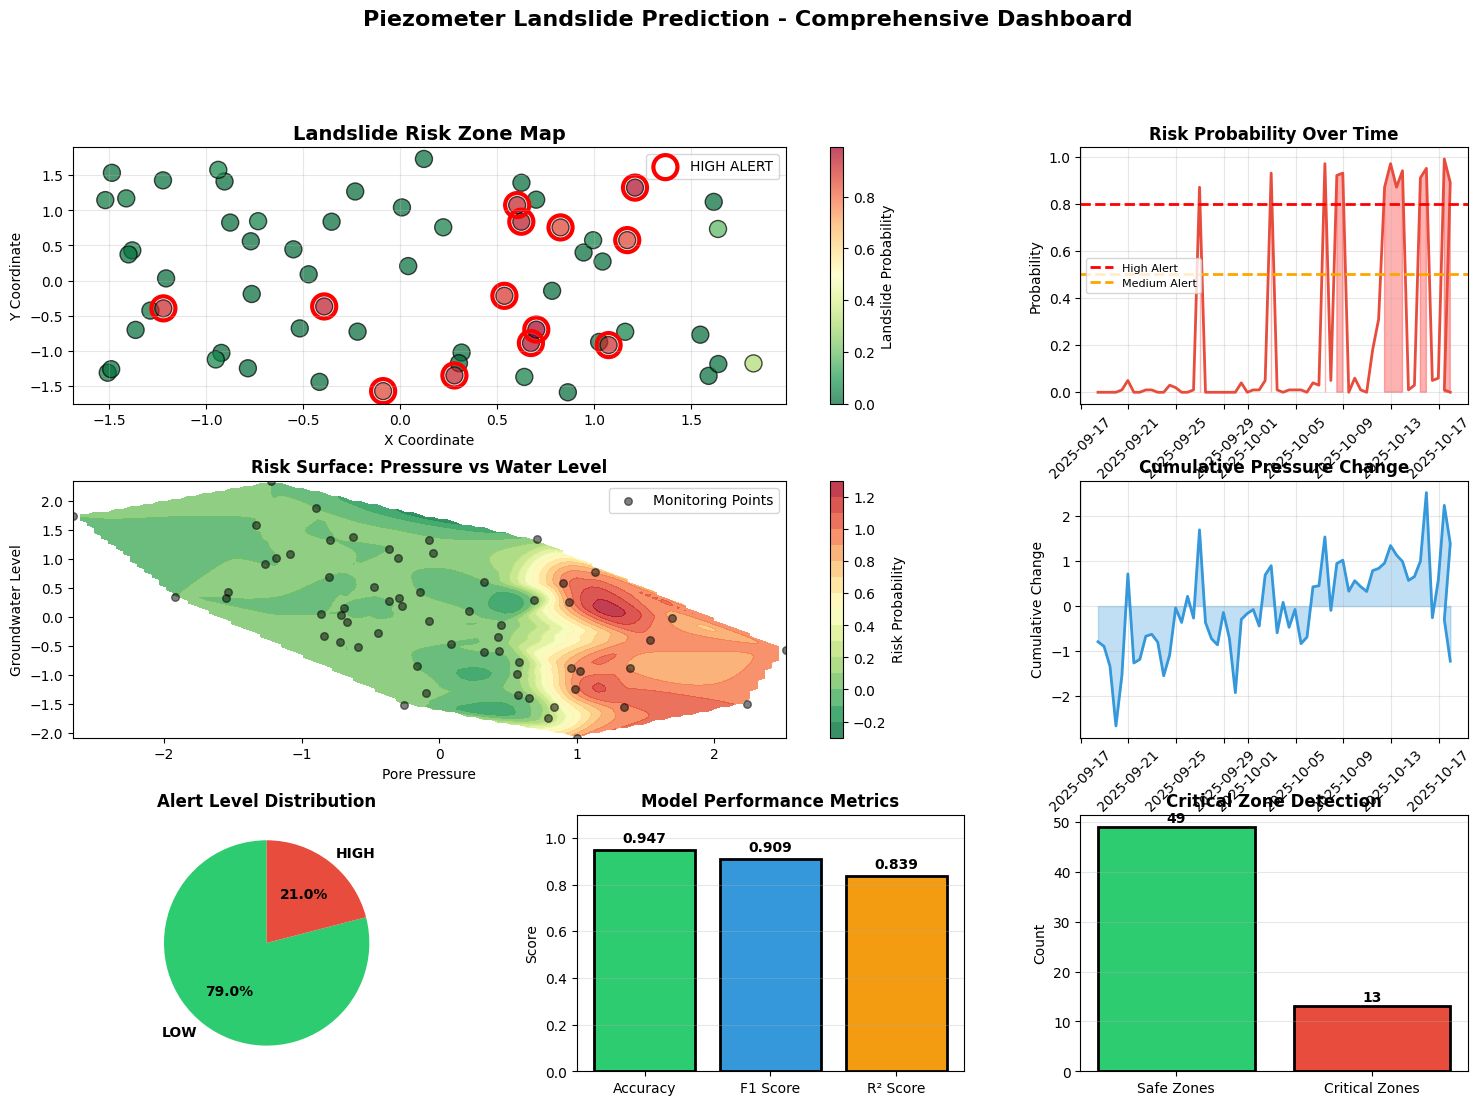


🚨 HIGH RISK ALERTS
Number of high-risk locations: 13

📍 Location: 42.75, 2.54, 321.58
   Risk Probability: 87.0%
   Pore Pressure: 1.69 (normalized)
   Groundwater Level: -0.01 (normalized)
   Risk Class: High

📍 Location: 53.58, 9.03, 467.06
   Risk Probability: 93.0%
   Pore Pressure: 0.90 (normalized)
   Groundwater Level: 0.58 (normalized)
   Risk Class: High

📍 Location: 65.20, 22.43, 442.44
   Risk Probability: 97.0%
   Pore Pressure: 1.53 (normalized)
   Groundwater Level: -0.39 (normalized)
   Risk Class: High

📍 Location: 9.37, 36.77, 353.04
   Risk Probability: 92.0%
   Pore Pressure: 0.95 (normalized)
   Groundwater Level: 0.26 (normalized)
   Risk Class: High

📍 Location: 63.11, 79.48, 400.53
   Risk Probability: 93.0%
   Pore Pressure: 1.02 (normalized)
   Groundwater Level: -0.94 (normalized)
   Risk Class: High

📍 Location: 69.70, 70.25, 371.90
   Risk Probability: 87.0%
   Pore Pressure: 0.96 (normalized)
   Groundwater Level: -0.88 (normalized)
   Risk Class: High

📍 

In [13]:
# Risk Zone Visualization
risk_probs = rf_model.predict_proba(X)[:, 1]

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. 2D Risk Map
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(processed_df['coord_x'], processed_df['coord_y'],
                     c=risk_probs, cmap='RdYlGn_r', s=150, 
                     edgecolors='black', linewidth=1, alpha=0.7)
high_risk_mask = risk_probs > 0.8
if high_risk_mask.any():
    ax1.scatter(processed_df[high_risk_mask]['coord_x'],
               processed_df[high_risk_mask]['coord_y'],
               facecolors='none', edgecolors='red', s=300,
               linewidth=3, label='HIGH ALERT')
plt.colorbar(scatter, ax=ax1, label='Landslide Probability')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_title('Landslide Risk Zone Map', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk Probability Timeline
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(processed_df['timestamp'], risk_probs, color='#E74C3C', linewidth=2)
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='High Alert')
ax2.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Alert')
ax2.fill_between(processed_df['timestamp'], risk_probs, 
                where=(risk_probs > 0.8), alpha=0.3, color='red')
ax2.set_title('Risk Probability Over Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Probability')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Pressure-Water Level Risk Surface
ax3 = fig.add_subplot(gs[1, :2])
# Create grid for interpolation
xi = np.linspace(processed_df['pore_pressure'].min(), processed_df['pore_pressure'].max(), 100)
yi = np.linspace(processed_df['groundwater_level'].min(), processed_df['groundwater_level'].max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((processed_df['pore_pressure'], processed_df['groundwater_level']), 
             risk_probs, (xi, yi), method='cubic')
contour = ax3.contourf(xi, yi, zi, levels=15, cmap='RdYlGn_r', alpha=0.8)
ax3.scatter(processed_df['pore_pressure'], processed_df['groundwater_level'],
           c='black', s=30, alpha=0.5, label='Monitoring Points')
plt.colorbar(contour, ax=ax3, label='Risk Probability')
ax3.set_xlabel('Pore Pressure')
ax3.set_ylabel('Groundwater Level')
ax3.set_title('Risk Surface: Pressure vs Water Level', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Cumulative Pressure Trend
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(processed_df['timestamp'], processed_df['cumulative_pressure_change'],
        color='#3498DB', linewidth=2)
ax4.fill_between(processed_df['timestamp'], processed_df['cumulative_pressure_change'],
                alpha=0.3, color='#3498DB')
ax4.set_title('Cumulative Pressure Change', fontsize=12, fontweight='bold')
ax4.set_ylabel('Cumulative Change')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Risk Distribution Pie
ax5 = fig.add_subplot(gs[2, 0])
alert_levels = ['LOW' if p < 0.5 else 'MEDIUM' if p < 0.8 else 'HIGH' for p in risk_probs]
alert_counts = pd.Series(alert_levels).value_counts()
colors_pie = {'LOW': '#2ECC71', 'MEDIUM': '#F39C12', 'HIGH': '#E74C3C'}
ax5.pie(alert_counts.values, labels=alert_counts.index, autopct='%1.1f%%',
       colors=[colors_pie[x] for x in alert_counts.index], startangle=90,
       textprops={'fontweight': 'bold'})
ax5.set_title('Alert Level Distribution', fontsize=12, fontweight='bold')

# 6. Model Performance Comparison
ax6 = fig.add_subplot(gs[2, 1])
metrics = ['Accuracy', 'F1 Score', 'R² Score']
scores = [clf_accuracy, clf_f1, reg_r2]
bars = ax6.bar(metrics, scores, color=['#2ECC71', '#3498DB', '#F39C12'], edgecolor='black', linewidth=2)
ax6.set_ylim(0, 1.1)
ax6.set_ylabel('Score')
ax6.set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Critical Zones Indicator
ax7 = fig.add_subplot(gs[2, 2])
critical = processed_df['critical_zone'].sum()
safe = len(processed_df) - critical
ax7.bar(['Safe Zones', 'Critical Zones'], [safe, critical],
       color=['#2ECC71', '#E74C3C'], edgecolor='black', linewidth=2)
ax7.set_ylabel('Count')
ax7.set_title('Critical Zone Detection', fontsize=12, fontweight='bold')
for i, v in enumerate([safe, critical]):
    ax7.text(i, v + 1, str(v), ha='center', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('Piezometer Landslide Prediction - Comprehensive Dashboard', 
            fontsize=16, fontweight='bold', y=0.995)

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'risk_dashboard', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

# Print alerts
high_risk_points = processed_df[risk_probs > 0.8]
print("\n" + "="*80)
print("🚨 HIGH RISK ALERTS")
print("="*80)
if len(high_risk_points) > 0:
    print(f"Number of high-risk locations: {len(high_risk_points)}\n")
    for idx, row in high_risk_points.iterrows():
        prob = risk_probs[idx]
        print(f"📍 Location: {row['point_coordinates']}")
        print(f"   Risk Probability: {prob:.1%}")
        print(f"   Pore Pressure: {row['pore_pressure']:.2f} (normalized)")
        print(f"   Groundwater Level: {row['groundwater_level']:.2f} (normalized)")
        print(f"   Risk Class: {row['risk_class']}")
        print()
else:
    print("✓ No high-risk locations detected. All systems normal.")

## 8. Real-time Monitoring Simulation

Simulate new piezometer readings and generate real-time predictions.

🔄 Simulating new piezometer readings...

NEW PIEZOMETER READINGS ANALYSIS
                 timestamp    point_coordinates  pore_pressure  groundwater_level  risk_probability  days_until_event alert_level
2025-10-24 19:50:47.627867 73.20, 59.87, 331.20      52.483571           4.930868              0.91          1.000075        HIGH
2025-10-25 07:50:47.627867  70.81, 2.06, 493.98      51.695206           5.455258              0.00          6.999916         LOW
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\realtime_readings.png
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\images\realtime_readings.png


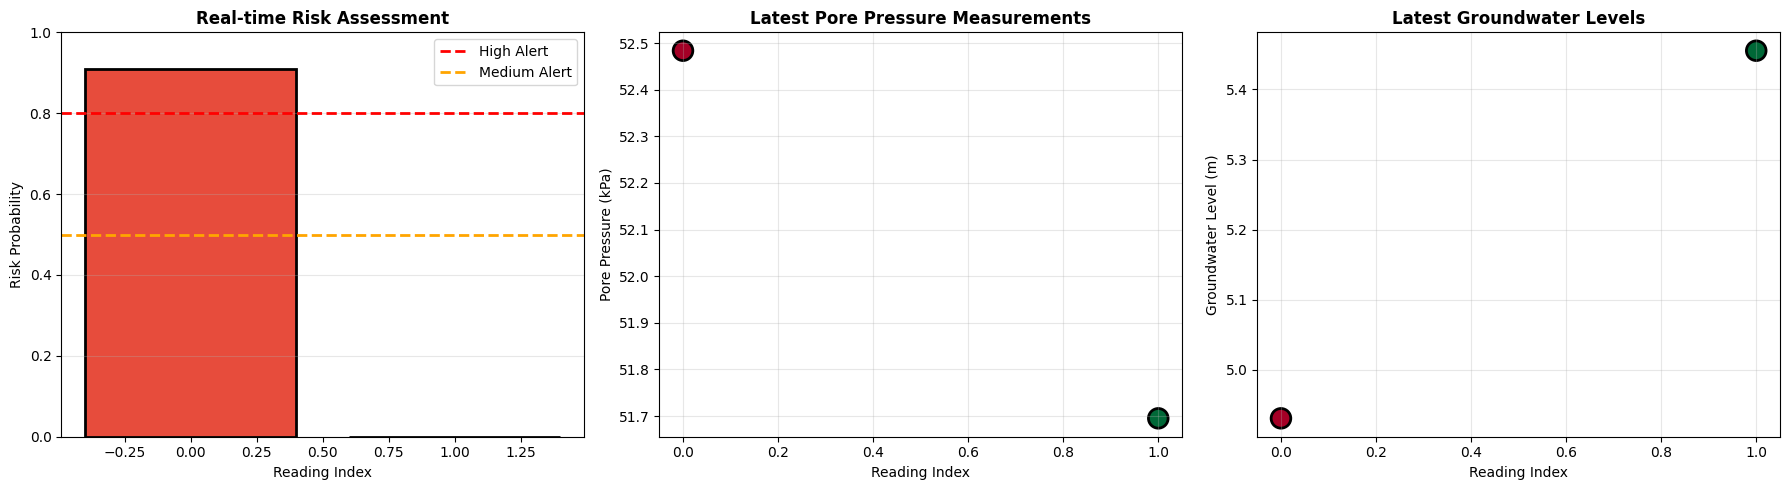


🚨 ALERT: High-risk readings detected!

   📍 Location: 73.20, 59.87, 331.20
   🔴 Risk Level: 91.0%
   ⏱️  Estimated days until event: 1.0
   💧 Pore Pressure: 52.48 kPa
   🌊 Groundwater Level: 4.93 m


In [14]:
# Generate new simulated readings
def append_new_piezometer_readings(n_readings=2):
    """
    Generate and append new piezometer readings to the dataset.
    Simulates 2 readings per day.
    """
    new_data = generate_piezometer_data(n_readings)
    
    # Append to CSV file
    new_data.to_csv(DATA_FILE, mode='a', header=False, index=False)
    
    # Process new data
    processed_new, _ = preprocess_piezometer_data(new_data)
    
    # Make predictions
    X_new = processed_new[feature_cols]
    occurrence_prob = rf_model.predict_proba(X_new)[:, 1]
    days_pred = gb_model.predict(X_new)
    
    # Create results dataframe
    results = pd.DataFrame({
        'timestamp': new_data['timestamp'],
        'point_coordinates': new_data['point_coordinates'],
        'pore_pressure': new_data['pore_pressure'],
        'groundwater_level': new_data['groundwater_level'],
        'risk_probability': occurrence_prob,
        'days_until_event': days_pred,
        'alert_level': ['HIGH' if p > 0.8 else 'MEDIUM' if p > 0.5 else 'LOW' for p in occurrence_prob]
    })
    
    return results

# Simulate new readings
print("🔄 Simulating new piezometer readings...\n")
new_readings = append_new_piezometer_readings(2)

print("="*80)
print("NEW PIEZOMETER READINGS ANALYSIS")
print("="*80)
print(new_readings.to_string(index=False))

# Visualize new readings
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Risk probability
colors_alert = ['#2ECC71' if x == 'LOW' else '#F39C12' if x == 'MEDIUM' else '#E74C3C' 
               for x in new_readings['alert_level']]
ax1.bar(range(len(new_readings)), new_readings['risk_probability'], 
       color=colors_alert, edgecolor='black', linewidth=2)
ax1.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='High Alert')
ax1.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Alert')
ax1.set_xlabel('Reading Index')
ax1.set_ylabel('Risk Probability')
ax1.set_title('Real-time Risk Assessment', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

# Pore pressure
ax2.scatter(range(len(new_readings)), new_readings['pore_pressure'], 
           c=new_readings['risk_probability'], cmap='RdYlGn_r', s=200,
           edgecolors='black', linewidth=2)
ax2.set_xlabel('Reading Index')
ax2.set_ylabel('Pore Pressure (kPa)')
ax2.set_title('Latest Pore Pressure Measurements', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Groundwater level
ax3.scatter(range(len(new_readings)), new_readings['groundwater_level'], 
           c=new_readings['risk_probability'], cmap='RdYlGn_r', s=200,
           edgecolors='black', linewidth=2)
ax3.set_xlabel('Reading Index')
ax3.set_ylabel('Groundwater Level (m)')
ax3.set_title('Latest Groundwater Levels', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure with versioning
fig_path = get_next_filename(IMAGES_DIR, 'realtime_readings', '.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

# Print alerts for new readings
if any(new_readings['alert_level'] == 'HIGH'):
    print("\n🚨 ALERT: High-risk readings detected!")
    alert_readings = new_readings[new_readings['alert_level'] == 'HIGH']
    for idx, row in alert_readings.iterrows():
        print(f"\n   📍 Location: {row['point_coordinates']}")
        print(f"   🔴 Risk Level: {row['risk_probability']:.1%}")
        print(f"   ⏱️  Estimated days until event: {row['days_until_event']:.1f}")
        print(f"   💧 Pore Pressure: {row['pore_pressure']:.2f} kPa")
        print(f"   🌊 Groundwater Level: {row['groundwater_level']:.2f} m")
elif any(new_readings['alert_level'] == 'MEDIUM'):
    print("\n⚠️  WARNING: Medium-risk readings detected. Monitor closely.")
else:
    print("\n✓ All new readings within safe parameters.")

## 9. System Summary and Report Generation

In [18]:
# Generate comprehensive system report
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

# Load all data (using DATA_FILE from Cell 3 initialization)
full_data = pd.read_csv(DATA_FILE)

# Recalculate model metrics using the trained models
processed_df, _ = preprocess_piezometer_data(full_data)
X = processed_df[feature_cols]
y_class = processed_df['landslide_likely']
y_reg = processed_df['days_until_event']

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg, test_size=0.3, random_state=42
)

# Get predictions for metrics
y_pred_class = rf_model.predict(X_test)
y_pred_reg = gb_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, r2_score
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
r2 = r2_score(y_test_reg, y_pred_reg)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_pairs = list(zip(feature_cols, importances))
sorted_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Calculate statistics
report = {
    "system_name": "Piezometer Landslide Prediction System",
    "report_generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_statistics": {
        "total_readings": len(full_data),
        "monitoring_points": full_data['point_coordinates'].nunique(),
        "date_range": {
            "start": full_data['timestamp'].min(),
            "end": full_data['timestamp'].max()
        },
        "pore_pressure": {
            "min": float(full_data['pore_pressure'].min()),
            "max": float(full_data['pore_pressure'].max()),
            "mean": float(full_data['pore_pressure'].mean()),
            "std": float(full_data['pore_pressure'].std())
        },
        "groundwater_level": {
            "min": float(full_data['groundwater_level'].min()),
            "max": float(full_data['groundwater_level'].max()),
            "mean": float(full_data['groundwater_level'].mean()),
            "std": float(full_data['groundwater_level'].std())
        },
        "risk_distribution": full_data['risk_class'].value_counts().to_dict()
    },
    "model_performance": {
        "classification_model": {
            "type": "RandomForestClassifier",
            "accuracy": float(accuracy),
            "f1_score": float(f1)
        },
        "regression_model": {
            "type": "GradientBoostingRegressor",
            "r2_score": float(r2)
        }
    },
    "top_features": {
        feature: float(importance) 
        for feature, importance in sorted_features[:5]
    }
}

# Save comprehensive dashboard JSON with versioning (for 2 charts only)
dashboard_data = {
    "system_name": "Piezometer Landslide Prediction System",
    "report_generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "chart_1_pressure_trends": {
        "timestamps": processed_df['timestamp'].astype(str).tolist(),
        "pore_pressure": processed_df['pore_pressure'].tolist(),
        "groundwater_level": processed_df['groundwater_level'].tolist()
    },
    "chart_2_risk_distribution": {
        "risk_classes": list(report['data_statistics']['risk_distribution'].keys()),
        "counts": list(report['data_statistics']['risk_distribution'].values())
    },
    "summary": {
        "total_readings": report['data_statistics']['total_readings'],
        "monitoring_points": report['data_statistics']['monitoring_points'],
        "high_risk_percentage": (report['data_statistics']['risk_distribution'].get('High', 0) / 
                                report['data_statistics']['total_readings'] * 100)
    }
}

dashboard_file = get_next_filename(ANALYSIS_DIR, 'dashboard', '.json')
with open(dashboard_file, 'w') as f:
    json.dump(dashboard_data, f, indent=4)
print(f"\n✓ Dashboard JSON saved to: {dashboard_file}")

# Save comprehensive report JSON with versioning
report_file = get_next_filename(ANALYSIS_DIR, 'system_report', '.json')
with open(report_file, 'w') as f:
    json.dump(report, f, indent=4)

print("="*80)
print("PIEZOMETER LANDSLIDE PREDICTION SYSTEM - FINAL REPORT")
print("="*80)
print(f"\n📊 System: {report['system_name']}")
print(f"⏰ Generated: {report['report_generated']}")
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"📈 Total Readings: {report['data_statistics']['total_readings']}")
print(f"📍 Monitoring Points: {report['data_statistics']['monitoring_points']}")
print(f"📅 Date Range: {report['data_statistics']['date_range']['start']} → {report['data_statistics']['date_range']['end']}")

print("\n💧 Pore Pressure Statistics:")
print(f"   • Mean: {report['data_statistics']['pore_pressure']['mean']:.2f} kPa")
print(f"   • Range: {report['data_statistics']['pore_pressure']['min']:.2f} - {report['data_statistics']['pore_pressure']['max']:.2f} kPa")
print(f"   • Std Dev: {report['data_statistics']['pore_pressure']['std']:.2f} kPa")

print("\n🌊 Groundwater Level Statistics:")
print(f"   • Mean: {report['data_statistics']['groundwater_level']['mean']:.2f} m")
print(f"   • Range: {report['data_statistics']['groundwater_level']['min']:.2f} - {report['data_statistics']['groundwater_level']['max']:.2f} m")
print(f"   • Std Dev: {report['data_statistics']['groundwater_level']['std']:.2f} m")

print("\n🎯 Risk Distribution:")
for risk, count in report['data_statistics']['risk_distribution'].items():
    print(f"   • {risk}: {count} readings ({count/report['data_statistics']['total_readings']*100:.1f}%)")

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print(f"🤖 Classification Model: {report['model_performance']['classification_model']['type']}")
print(f"   • Accuracy: {report['model_performance']['classification_model']['accuracy']:.1%}")
print(f"   • F1-Score: {report['model_performance']['classification_model']['f1_score']:.3f}")

print(f"\n📉 Regression Model: {report['model_performance']['regression_model']['type']}")
print(f"   • R² Score: {report['model_performance']['regression_model']['r2_score']:.3f}")

print("\n🔝 Top 5 Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:5], 1):
    print(f"   {i}. {feature}: {importance:.3f}")

print("\n" + "="*80)
print("GENERATED FILES")
print("="*80)
print(f"✓ Dashboard JSON: {dashboard_file}")
print(f"✓ System Report JSON: {report_file}")
print(f"✓ Data File: {DATA_FILE}")

print("\n" + "="*80)
print(f"📄 Reports saved successfully!")
print("="*80)

# Generate PDF Report with versioning
from matplotlib.backends.backend_pdf import PdfPages

pdf_file = get_next_filename(REPORT_DIR, 'report', '.pdf')
with PdfPages(pdf_file) as pdf:
    # Page 1: Title and Summary
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    
    # Title
    plt.text(0.5, 0.95, 'PIEZOMETER LANDSLIDE PREDICTION', 
            ha='center', va='top', fontsize=20, fontweight='bold')
    plt.text(0.5, 0.92, 'System Report', 
            ha='center', va='top', fontsize=16)
    plt.text(0.5, 0.89, f"Generated: {report['report_generated']}", 
            ha='center', va='top', fontsize=10)
    
    # Data Summary
    plt.text(0.1, 0.82, 'DATA SUMMARY', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.78, f"Total Readings: {report['data_statistics']['total_readings']}", fontsize=10)
    plt.text(0.1, 0.75, f"Monitoring Points: {report['data_statistics']['monitoring_points']}", fontsize=10)
    plt.text(0.1, 0.72, f"Date Range: {report['data_statistics']['date_range']['start']} → {report['data_statistics']['date_range']['end']}", fontsize=9)
    
    # Pore Pressure Stats
    plt.text(0.1, 0.65, 'Pore Pressure Statistics:', fontsize=12, fontweight='bold')
    plt.text(0.15, 0.62, f"Mean: {report['data_statistics']['pore_pressure']['mean']:.2f} kPa", fontsize=10)
    plt.text(0.15, 0.59, f"Range: {report['data_statistics']['pore_pressure']['min']:.2f} - {report['data_statistics']['pore_pressure']['max']:.2f} kPa", fontsize=10)
    
    # Groundwater Level Stats
    plt.text(0.1, 0.52, 'Groundwater Level Statistics:', fontsize=12, fontweight='bold')
    plt.text(0.15, 0.49, f"Mean: {report['data_statistics']['groundwater_level']['mean']:.2f} m", fontsize=10)
    plt.text(0.15, 0.46, f"Range: {report['data_statistics']['groundwater_level']['min']:.2f} - {report['data_statistics']['groundwater_level']['max']:.2f} m", fontsize=10)
    
    # Model Performance
    plt.text(0.1, 0.39, 'MODEL PERFORMANCE', fontsize=14, fontweight='bold')
    plt.text(0.1, 0.35, f"Classification Accuracy: {report['model_performance']['classification_model']['accuracy']:.1%}", fontsize=10)
    plt.text(0.1, 0.32, f"F1-Score: {report['model_performance']['classification_model']['f1_score']:.3f}", fontsize=10)
    plt.text(0.1, 0.29, f"Regression R² Score: {report['model_performance']['regression_model']['r2_score']:.3f}", fontsize=10)
    
    # Top Features
    plt.text(0.1, 0.22, 'TOP 5 IMPORTANT FEATURES', fontsize=14, fontweight='bold')
    y_pos = 0.18
    for i, (feature, importance) in enumerate(sorted_features[:5], 1):
        plt.text(0.15, y_pos, f"{i}. {feature}: {importance:.3f}", fontsize=10)
        y_pos -= 0.03
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"✓ PDF Report generated: {pdf_file}")
print("="*80)
print("="*80)
print("\n✨ Piezometer Landslide Prediction System is ready!")
print("🚀 Use 'predict_landslide_risk()' function to make predictions on new data")
print(f"📊 All outputs saved to: {PIEZOMETER_DIR}")
print(f"   • Images: {IMAGES_DIR}")
print(f"   • Analysis: {ANALYSIS_DIR}")
print(f"   • Reports: {REPORT_DIR}")
print("="*80)


✓ Dashboard JSON saved to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Piezometer\Analysis\dashboard.json
PIEZOMETER LANDSLIDE PREDICTION SYSTEM - FINAL REPORT

📊 System: Piezometer Landslide Prediction System
⏰ Generated: 2025-10-25 20:01:40

DATA SUMMARY
📈 Total Readings: 64
📍 Monitoring Points: 62
📅 Date Range: 2025-09-18 10:51:10.920603 → 2025-10-25 07:50:47.627867

💧 Pore Pressure Statistics:
   • Mean: 58.49 kPa
   • Range: 37.84 - 78.45 kPa
   • Std Dev: 7.86 kPa

🌊 Groundwater Level Statistics:
   • Mean: 3.75 m
   • Range: 1.76 - 5.89 m
   • Std Dev: 0.96 m

🎯 Risk Distribution:
   • Medium: 31 readings (48.4%)
   • Low: 19 readings (29.7%)
   • High: 14 readings (21.9%)

MODEL PERFORMANCE
🤖 Classification Model: RandomForestClassifier
   • Accuracy: 100.0%
   • F1-Score: 1.000

📉 Regression Model: GradientBoostingRegressor
   • R² Score: 0.995

🔝 Top 5 Important Features:
   1. pore_pressure: 0.422
   2. cumulative_pressure_change: 0.361
   3. pressure_water_ratio: 